### About Dataset
This project focuses on developing a sentiment analysis system from social media posts. Using natural language processing techniques, the system aims to automatically identify and categorize the sentiment expressed within social media content.           
Source: https://www.kaggle.com/datasets/mdismielhossenabir/sentiment-analysis

In [142]:
# Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [143]:
# Importing dataset
df = pd.read_csv('/content/sentiment_analysis.csv') # Reading datset
df.head()                                           # Chceking head of the dataset

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


## Exploratory data analysis

In [144]:
# Checking the shape of the dataset
print(f"No. of rows: {df.shape[0]}")
print(f"No. of columns: {df.shape[1]}")

No. of rows: 499
No. of columns: 7


In [145]:
# Columns of the dataset
df.columns

Index(['Year', 'Month', 'Day', 'Time of Tweet', 'text', 'sentiment',
       'Platform'],
      dtype='object')

Inferrence: 7 columns in total, 6 input data column and sentiment is the output label column.

In [146]:
# Checking for null values
df.isnull().sum()

,0
Year,0
Month,0
Day,0
Time of Tweet,0
text,0
sentiment,0
Platform,0


Inferrence: no null values

In [147]:
# Getting statistical info on the dataset
df.describe()

,Year,Month,Day
count,499.000000,499.000000,499.000000
mean,2020.394790,6.084168,15.693387
std,2.830991,3.652711,8.804673
min,2010.000000,1.000000,1.000000
25%,2019.000000,2.000000,8.000000
50%,2021.000000,6.000000,15.000000
75%,2023.000000,9.000000,22.000000
max,2023.000000,12.000000,31.000000


In [148]:
# Getting general info on dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           499 non-null    int64 
 1   Month          499 non-null    int64 
 2   Day            499 non-null    int64 
 3   Time of Tweet  499 non-null    object
 4   text           499 non-null    object
 5   sentiment      499 non-null    object
 6   Platform       499 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.4+ KB


In [149]:
# Checking number of unique values in each coulmn
for column in df.columns:
  print(f'Unique values in {column}: {df[column].nunique()}')

Unique values in Year: 14
Unique values in Month: 12
Unique values in Day: 31
Unique values in Time of Tweet: 3
Unique values in text: 394
Unique values in sentiment: 3
Unique values in Platform: 5


Need to see the distribution of data in

<Axes: title={'center': 'Distribution of year column'}, xlabel='Year'>

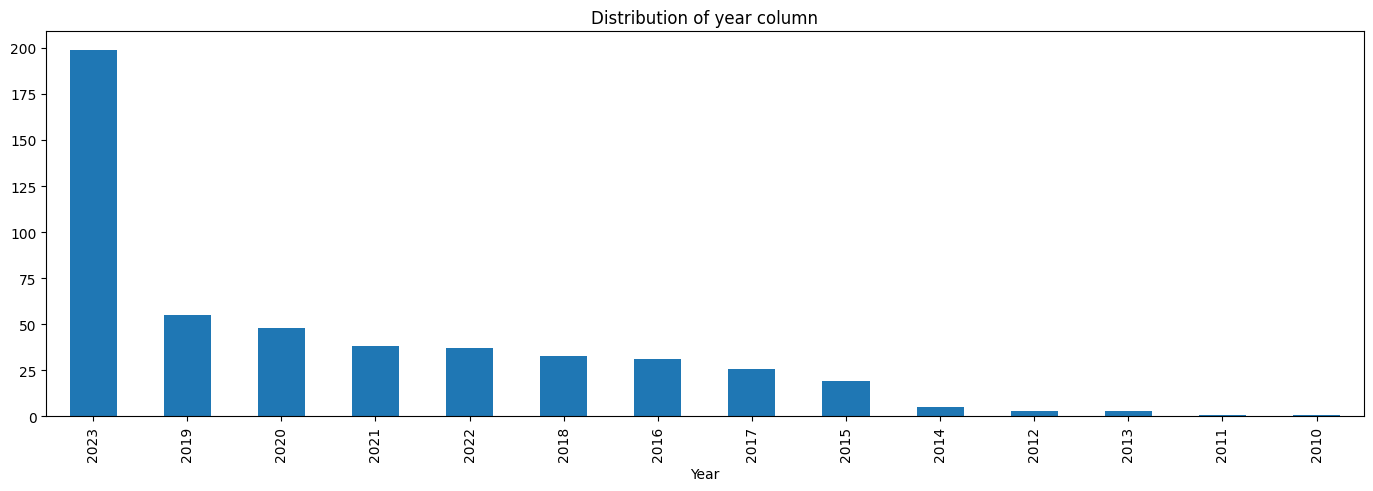

In [150]:
# plotting distribution of year column
plt.figure(figsize=(17,5))
plt.title("Distribution of year column")
df["Year"].value_counts().plot(kind="bar")

Year column has a terrible distribution. Most of the data is from 2023. So our model might get biased towards 2023 data. Best to remove the year column

<Axes: title={'center': 'Distribution of month column'}, xlabel='Month'>

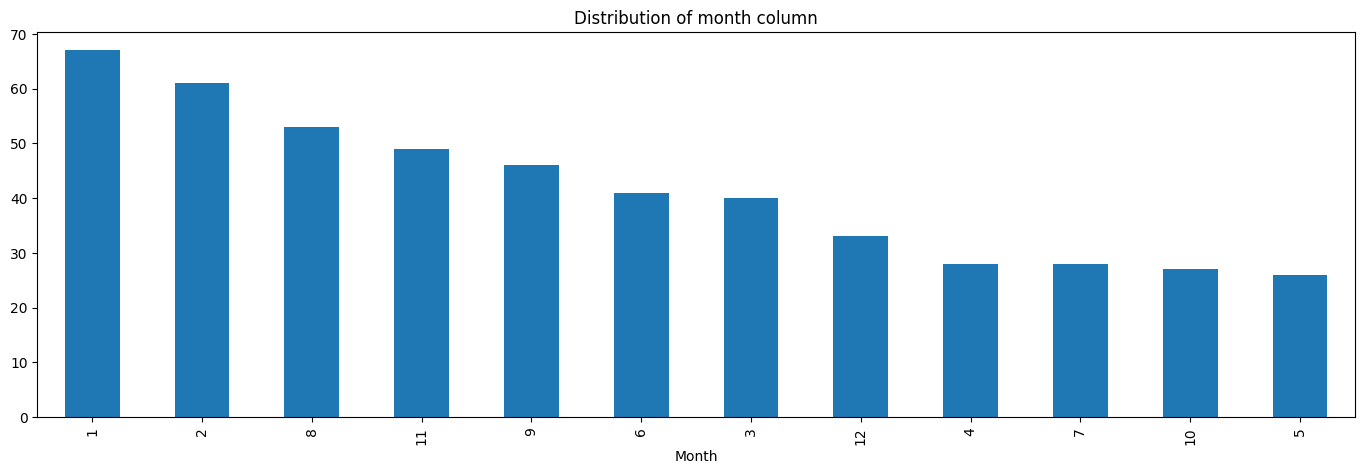

In [151]:
# plotting distribution of month column
plt.figure(figsize=(17,5))
plt.title("Distribution of month column")
df["Month"].value_counts().plot(kind="bar")

Distribution of data for month column seems fair.

<Axes: title={'center': 'Distribution of day column'}, xlabel='Day'>

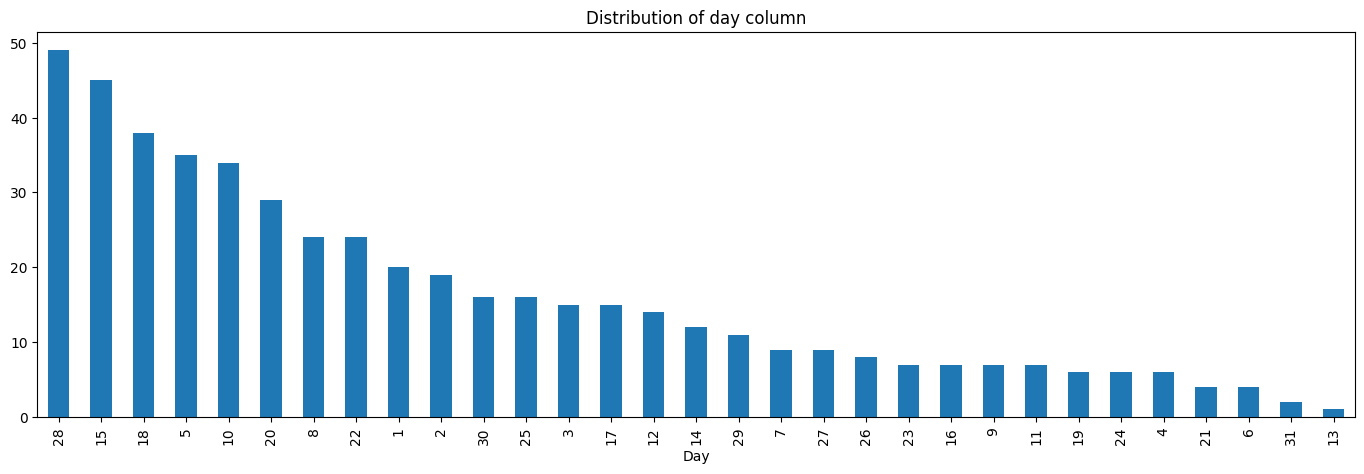

In [152]:
# plotting distribution of Day column
plt.figure(figsize=(17,5))
plt.title("Distribution of day column")
df["Day"].value_counts().plot(kind="bar")

Distribution for the day also seems fair enough.

<Axes: title={'center': 'Distribution of Time of tweet column'}, xlabel='Time of Tweet'>

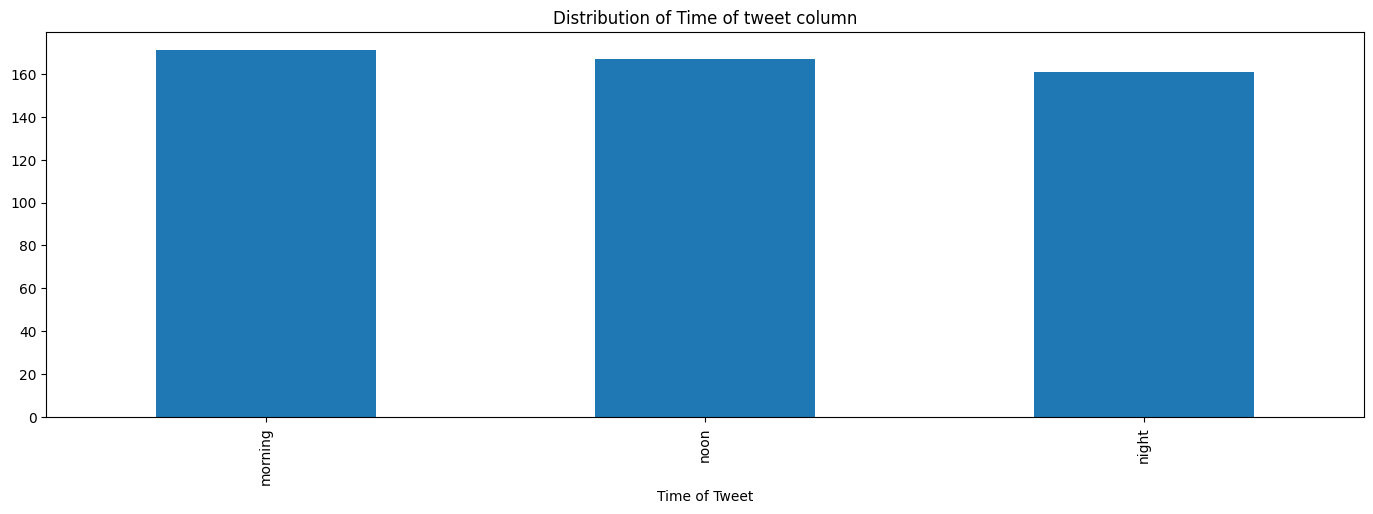

In [153]:
# plotting distribution of Time of Tweet column
plt.figure(figsize=(17,5))
plt.title("Distribution of Time of tweet column")
df["Time of Tweet"].value_counts().plot(kind="bar")

Extremely fair distribution

<Axes: title={'center': 'Distribution of sentiment column'}, xlabel='sentiment'>

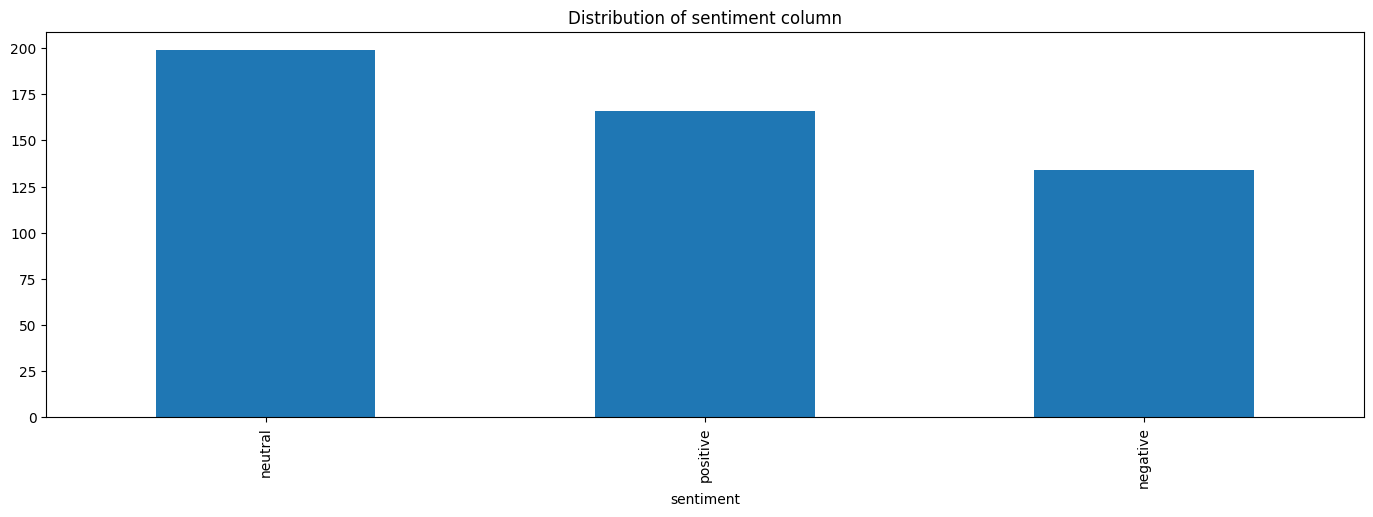

In [154]:
# plotting distribution of sentiment column
plt.figure(figsize=(17,5))
plt.title("Distribution of sentiment column")
df["sentiment"].value_counts().plot(kind="bar")

Distribution seems fair

<Axes: title={'center': 'Distribution of platform column'}, xlabel='Platform'>

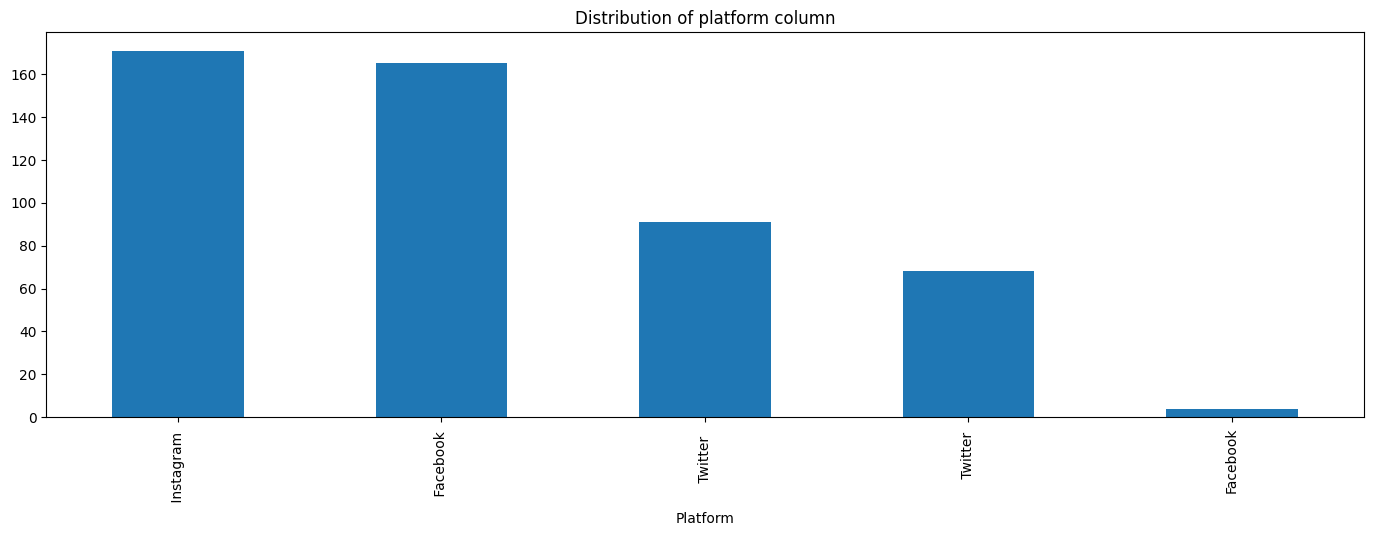

In [155]:
# plotting distribution of Platform column
plt.figure(figsize=(17,5))
plt.title("Distribution of platform column")
df["Platform"].value_counts().plot(kind="bar")

Facebook has extremely low quantity in comparison to others. Model might not accurately predict Facebook comments.

## Data Pre-processing
1. Need to remove the year column.
2. Need to label encode Time of Tweet, Sentiment and Platform columns.
3. Text processing Text column.

In [156]:
# Dropping the year column
df = df.drop("Year", axis=1)

In [157]:
# Label encoding the Time of Tweet, Sentiment and platform column

le = LabelEncoder()     # Creating an instance of label encoder
df["Time of Tweet"] = le.fit_transform(df["Time of Tweet"]) # For Time of tweet col
df["sentiment"] = le.fit_transform(df["sentiment"])         # For sentiment col
df["Platform"] = le.fit_transform(df["Platform"])           # For Platform col

## Text processing


In [158]:
# Creeating an instance of porter stemmer
stemmer = PorterStemmer()

# Creating a function to process text
def clean_text(text):
  clean_text = text.lower()
  clean_text = re.sub("[^a-zA-Z]", " ", clean_text)
  clean_text = word_tokenize(clean_text)
  clean_text = [stemmer.stem(word) for word in clean_text if word not in stopwords.words('english')]
  clean_text = " ".join(clean_text)
  return clean_text

In [159]:
# Applying clean text function to text column
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [160]:
# Creating an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fitting the data
vectorized_data = vectorizer.fit_transform(df['text'].values).toarray()

# Setting column names
col_names = vectorizer.get_feature_names_out()

# Creating a dataset of vectorized array
vec = pd.DataFrame(vectorized_data, columns=col_names)

In [161]:
# concatenating the vectorized column to the dataset
df = pd.concat([df, vec], axis=1)

In [162]:
# Dropping the text column
df = df.drop("text", axis=1)

In [163]:
# Splitting data into data and labels
X = df.drop("sentiment", axis=1).values   # Input data
y = df["sentiment"].values                # Labels

print(X.shape)                            # Checking shape of input data
print(y.shape)                            # Checking label shape

(499, 1140)
(499,)


In [164]:
# Scaling X
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [165]:
# Checking input codes
X

array([[ 0.52502213,  0.26223892, -1.20536111, ..., -0.04481107,
        -0.04481107, -0.06343615],
       [ 0.52502213,  0.26223892,  1.2248417 , ..., -0.04481107,
        -0.04481107, -0.06343615],
       [ 0.52502213,  0.26223892,  0.00974029, ..., -0.04481107,
        -0.04481107, -0.06343615],
       ...,
       [-0.29710981,  1.62651926,  1.2248417 , ..., -0.04481107,
        -0.04481107, -0.06343615],
       [ 0.52502213, -0.6472813 ,  0.00974029, ..., -0.04481107,
        -0.04481107, -0.06343615],
       [-0.84519777,  1.05806912, -1.20536111, ..., -0.04481107,
        -0.04481107, -0.06343615]])

In [166]:
# Checking labels
y

array([2, 2, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 2, 1, 2,
       1, 0, 1, 2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1,
       2, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1,
       2, 2, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 0, 0, 1, 0, 0, 1, 2, 2, 1, 2,
       1, 0, 1, 2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1,
       2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0,
       2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0,
       0, 1, 1, 2, 2, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 0, 2, 2, 1, 0, 1, 0, 1,
       0, 1, 1, 2, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 0, 1,
       2, 1, 1, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 2, 1, 1,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 0, 2,
       2, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 2,

### Train-Test-split

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Checking shape of all the divisions
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (399, 1140)
X_test shape: (100, 1140)
y_train shape: (399,)
y_test shape: (100,)


In [168]:
lr_model = LogisticRegression()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
svm_model = SVC()
knn_model = KNeighborsClassifier()
xgb_model = XGBClassifier()

models_list = [lr_model, dt_model, rf_model, svm_model, knn_model, xgb_model]

In [169]:
# Running a loop to train and see which model performs best
for model in models_list:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"{model} accuracy: {accuracy}")

LogisticRegression() accuracy: 0.64
DecisionTreeClassifier() accuracy: 0.64
RandomForestClassifier() accuracy: 0.63
SVC() accuracy: 0.49
KNeighborsClassifier() accuracy: 0.3
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) accuracy: 0.67


## Need more data to train the model